# **Stochastic Processes in Neuroscience: From ODEs to SDEs**


In neuroscience, variability is everywhere:
- Neuronal firing is probabilistic.
- Synaptic vesicle release is stochastic.
- Ion channel gating fluctuates.
- Sensory and internal signals are noisy.

Yet many of our models are deterministic.

This notebook shows how we can incorporate **stochastic processes** into classical ODE models of neurons, creating **stochastic differential equations** (SDEs) to better reflect biological reality.


## **Stochastic Differential Equations (SDEs)**

A **Stochastic Differential Equation (SDE)** is like an ordinary differential equation (ODE), but with an added **random component** to account for uncertainty or noise.

Where a ODE may follow the form:
$$
dX(t) = f(X(t), t) \, dt
$$

An SDE typically looks like this:

$$
dX(t) = f(X(t), t) \, dt + g(X(t), t) \, dW(t)
$$

Where:

- $X(t)$: the variable we're modeling (e.g., membrane potential)
- $f(X, t)$: the **deterministic drift** — same as in ODEs
- $g(X, t)$: the **noise strength** or **diffusion coefficient**
- $dW(t)$: a **Wiener process** increment (also called Brownian motion)


Think of $dW(t)$ as a random variable "kick" at every time step:

It follows the normal (Gaussian) distribution with **mean 0** and **variance $dt$**:  
 $$dW(t) \sim \mathcal{N}(0, dt)$$



## **Review: Deterministic Leaky Integrate-and-Fire Model**

The simple LIF neuron model considers the change in neuronal membrane potential as a function of an input current $I(t)$ and
$$
\tau_m \frac{dV}{dt} = - (V - V_{rest}) +  \frac{I(t)}{g_L}
$$

or equivalently
$$
dV = \frac{1}{\tau_m}\left[ {-(V - V_{rest})} + \frac{I(t)}{g_L} \right] dt
$$
- $V$: membrane potential  
- $V_{rest}$: resting potential
- $\tau_m$: membrane time constant  
- $I(t)$: input current  
- $g_L$: leak conductance


Text(0, 0.5, 'Membrane Potential (mV)')

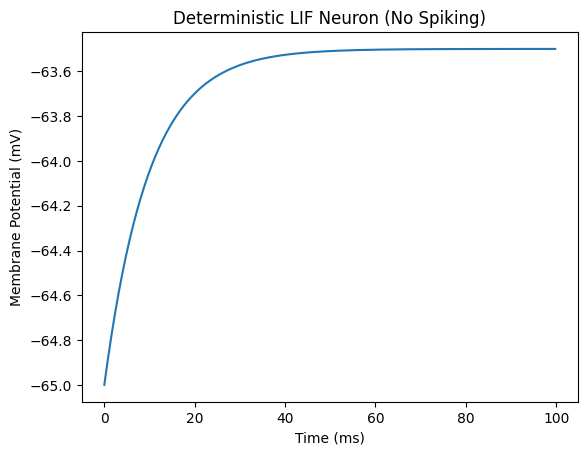

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T, dt = 100, 0.2
tau, V_rest, g_L, I = 10, -65, 1, 1.5
time = np.arange(0, T, dt)
V = np.zeros_like(time)
V[0] = V_rest

# Deterministic LIF simulation
for i in range(1, len(time)):
    dV = (- (V[i-1] - V_rest) +  (I/g_L)) * dt / tau
    V[i] = V[i-1] + dV

plt.plot(time, V)
plt.title("Deterministic LIF Neuron (No Spiking)")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")


## **Adding Noise: Stochastic Leaky Integrate-and-Fire Model**

Biological neurons experience fluctuations from:
- Synaptic bombardment (spontaneous spikes)
- Channel noise (discrete ion channel gating)
- Thermal effects and background activity

We can model these by adding a stochastic term:
$$
dV = \frac{1}{\tau_m}\left[ {(V - V_{rest})} + \frac{I(t)}{g_L} \right] dt + \sigma dW(t)
$$
Where:
- $ \sigma $ controls the **strength of noise fluctuations**
- $ dW(t) $ is a Wiener process (Brownian motion increment):
$$
𝑑𝑊(𝑡) ∼ 𝑁(0, 𝑑𝑡)
$$

 meaning the change in $W(t)$ follows a normal (or **Gaussian**) distribution with mean 0, and variance $dt$.

Its *Markov Property* means that the future value of $W(t)$, i.e. $W(t+1)$ depends only on its current value, not on its history.

**Note**: $dW(t)$ is formally not a derivative, even though it’s often written as one.


## **Numerically Solving SDEs: Euler–Maruyama Method**

The Euler-Maruyama method is a variation of Euler’s method that accounts for stochasticity and implements the *random walk*.

We know that in our deterministic LIF model
$$
dV = \frac{1}{\tau_m}\left[ {-(V - V_{rest})} + \frac{I(t)}{g_L} \right] dt
$$

and that
$$V_{t+1}=V_t+dV$$
so that

$$
V_{t+1} = V_t + \frac{1}{\tau_m}\left[ {-(V - V_{rest})} + \frac{I(t)}{g_L} \right] dt
$$

To extend the Euler method to numerical simulate the stochastic LIF model, we simply add a Gaussian noise term **$\sigma \sqrt{dt} \cdot N(0,1)$** at each time step.
$$
V_{t+1} = V_t + \frac{1}{\tau_m}\left[ -(V - V_{rest}) + \frac{I(t)}{g_L} \right] dt  + \sigma \sqrt{dt} \cdot N(0,1)
$$



Text(0, 0.5, 'Membrane Potential (mV)')

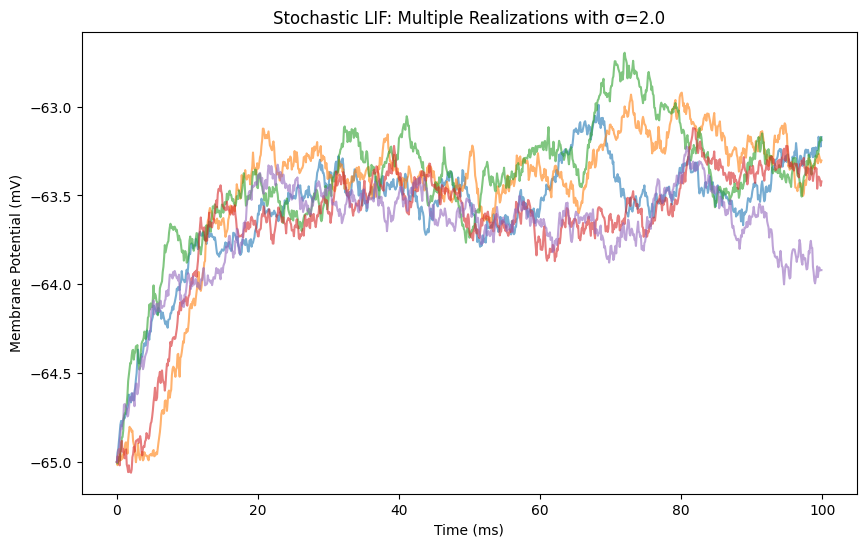

In [4]:
def stochastic_LIF(T=100, dt=0.1, tau=10, V_rest=-65, R=1, I=1.5, sigma=1.0):
    """
    Simulates a stochastic LIF neuron using the Euler-Maruyama method.

    Returns:
        time: simulation time array
        V: membrane potential over time
    """
    time = np.arange(0, T, dt)
    V = np.zeros_like(time)
    V[0] = V_rest

    for i in range(1, len(time)):
        noise = np.random.normal(0, np.sqrt(dt))
        drift = (- (V[i-1] - V_rest) + R * I) / tau
        V[i] = V[i-1] + drift * dt + sigma * noise

    return time, V


plt.figure(figsize=(10, 6))
for _ in range(5):
    t, V = stochastic_LIF(sigma=0.1)
    plt.plot(t, V, alpha=0.6)

plt.title("Stochastic LIF: Multiple Realizations with σ=2.0")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")


### **Varying Noise Strength**

In the stochastic LIF model, the variable $\sigma$ controls the amplitude of these fluctuations, and is often referred to as the noise strength.

In real neurons, membrane potential doesn't evolve deterministically. It is influenced by:

- Thermal noise in ion channels

- Random synaptic inputs from other neurons firing stochastically

- Fluctuations in neurotransmitter release at synapses

- Spontaneous release of vesicles

All these effects introduce variability into the neuron's behavior, even under seemingly identical conditions.

So $\sigma$ in the model doesn't just add randomness for the sake of simulation, it captures real biological uncertainty and variability in neuronal dynamics.

**What happens as we increase $\sigma$?**

With **low $\sigma$**, the trajectory is smooth and mostly deterministic.

With **high $\sigma$**, the membrane potential becomes more volatile and noisy.


Text(0, 0.5, 'Membrane Potential (mV)')

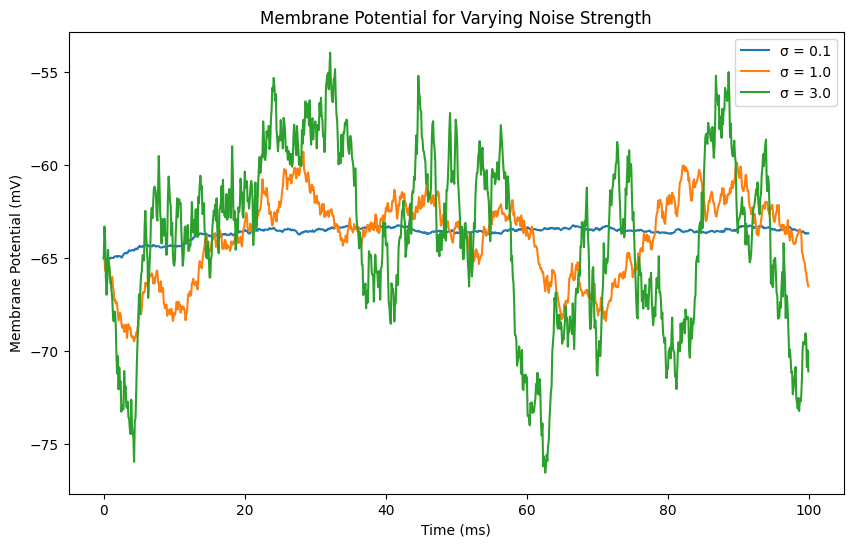

In [5]:
sigmas = [0.1, 1.0, 3.0]
plt.figure(figsize=(10, 6))
for sigma in sigmas:
    t, V = stochastic_LIF(sigma=sigma)
    plt.plot(t, V, label=f"σ = {sigma}")

plt.title("Membrane Potential for Varying Noise Strength")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")


### **Controlling Randomness with a Seed**
Stochastic simulations, like the LIF model you've just run, involve randomness—specifically, in how noise is added to the system. Each time you run the simulation, the random numbers (used for the noise term) will be different unless you explicitly control them. This can make it difficult to:

- **Reproduce results**: You may want to revisit an interesting behavior you observed in one simulation, but if the random numbers change every run, the behavior might not appear again.

- **Compare variations**: When testing how parameters like σ affect variability, you'd want to isolate the effect of that parameter alone, not additional changes from a different random seed.

- **Debug your model**: A fixed sequence of random numbers ensures your model behaves consistently across changes, helping you detect when a change in output is due to code changes and not just randomness.


To make your stochastic LIF simulations reproducible, you can use a random seed. A seed is simply a fixed starting point for the random number generator. By setting it, you ensure that the same sequence of random numbers is used each time you run the code. Each curve will still be different (because the seed changes), but the results are now repeatable: the same seed will always produce the same trajectory.



Text(0, 0.5, 'Membrane Potential (mV)')

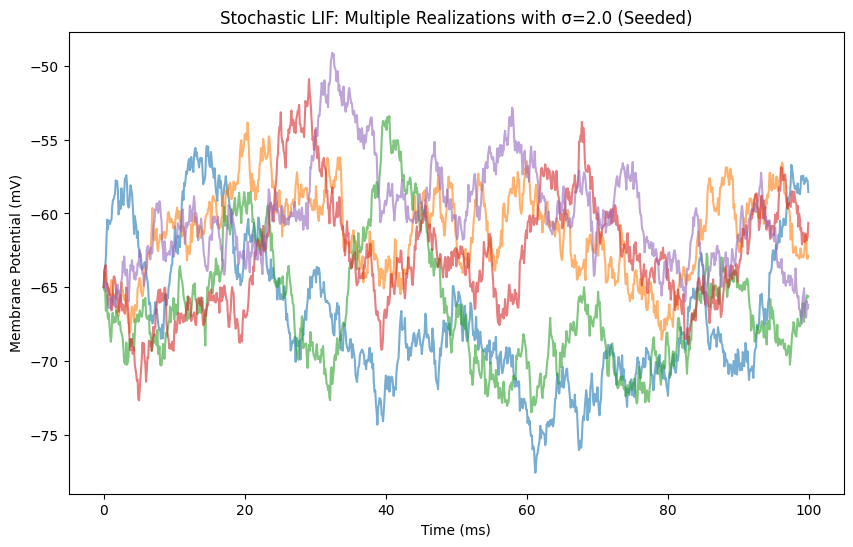

In [15]:
def stochastic_LIF(T=100, dt=0.1, tau=10, V_rest=-65, R=1, I=1.5, sigma=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set the seed for reproducibility

    time = np.arange(0, T, dt)
    V = np.zeros_like(time)
    V[0] = V_rest

    for i in range(1, len(time)):
        noise = np.random.normal(0, np.sqrt(dt))
        drift = (- (V[i-1] - V_rest) + R * I) / tau
        V[i] = V[i-1] + drift * dt + sigma * noise

    return time, V

plt.figure(figsize=(10, 6))
for i in range(5):
    t, V = stochastic_LIF(sigma=2.0, seed=i)  # Different but reproducible results
    plt.plot(t, V, alpha=0.6)

plt.title("Stochastic LIF: Multiple Realisations with σ=2.0 (Seeded)")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")

## **Stochastic Leaky Integrate-and-Fire Model (with Spiking)**

In the previous sections, we explored how noise affects membrane potential in a subthreshold regime—where the neuron does not emit spikes but still exhibits voltage fluctuations. Now, we incorporate a spike-generation mechanism, turning our stochastic model into a full Stochastic Leaky Integrate-and-Fire (LIF) neuron.

This model captures how random fluctuations, such as synaptic noise or ion channel variability, can cause a neuron to spike even when the mean input would not be sufficient in a purely deterministic model.

We use the same dynamics as in the subthreshold stochastic LIF model:
$$
dV=\frac{1}{\tau_m}\left[ -(V - V_{rest}) + \frac{I(t)}{g_L} \right] dt  + \sigma \sqrt{dt} \cdot N(0,1)
$$

But now we add two critical features:

- A **threshold** $𝑉_{thresh}$ : when the membrane potential crosses this value, the neuron emits a spike.
- A **reset** $𝑉_{reset}$: immediately after a spike, the membrane potential is set to this value.

This simple mechanism mimics action potentials without modeling all the biophysics of ion channels.

**When you run this model:**

- Spikes appear at **irregular intervals**, even though the input current is constant.

- The **noise strength** $\sigma$ critically determines how often the membrane potential fluctuates across the threshold.

- For **low noise**, the neuron may never spike.

- For **high noise**, it may spike frequently, even without a large deterministic drive.

This variability makes the stochastic LIF neuron a useful tool for studying **rate coding**, **spike timing variability**, and **probabilistic computation** in neural systems.

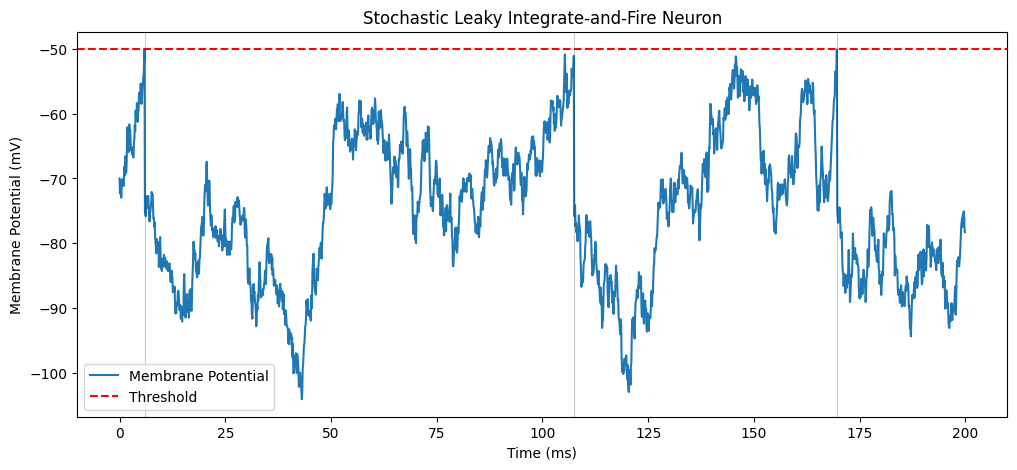

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
T = 200           # total time (ms)
dt = 0.1          # time step (ms)
time = np.arange(0, T, dt)

# LIF neuron parameters
tau = 20.0        # membrane time constant (ms)
V_rest = -70.0    # resting potential (mV)
V_reset = -75.0   # reset potential after spike (mV)
V_thresh = -50.0  # spike threshold (mV)
R = 1.0           # membrane resistance
I = 1.5           # input current (nA)
sigma = 5.0       # noise strength

# --- Initialization ---
V = np.zeros_like(time)
V[0] = V_rest
spike_times = []

# --- Simulation loop ---
for i in range(1, len(time)):
    noise = np.random.normal(0, np.sqrt(dt))
    dV = (- (V[i-1] - V_rest) + R * I) * (dt / tau) + sigma * noise
    V[i] = V[i-1] + dV

    if V[i] >= V_thresh:
        V[i] = V_reset
        spike_times.append(time[i])

# --- Plotting ---
plt.figure(figsize=(12, 5))

plt.plot(time, V, label='Membrane Potential')
plt.axhline(V_thresh, color='r', linestyle='--', label='Threshold')
plt.title("Stochastic Leaky Integrate-and-Fire Neuron")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()

# Mark spike times
for st in spike_times:
    plt.axvline(st, color='k', alpha=0.2, linewidth=0.8)

plt.show()


## **From Single Neurons to Neural Populations**

While studying individual stochastic neurons reveals how noise affects membrane dynamics and spike timing, the brain's computational power emerges from **populations of interacting neurons**. Real neural circuits contain thousands to millions of neurons, each experiencing independent noise fluctuations, yet somehow coordinating their activity to process information reliably.

This raises fascinating questions: How do noisy, unreliable individual neurons give rise to robust population-level computations? Can independent noise sources paradoxically create **synchronized firing patterns**? And what happens when we scale up our stochastic LIF model from a single neuron to an entire network?

To explore these questions, we'll now simulate **multiple stochastic LIF neurons** running in parallel. Each neuron will have its own independent noise source and slightly different parameters (reflecting biological heterogeneity), but they'll all follow the same underlying stochastic dynamics. By analyzing their collective behavior, we can discover how **noise-driven synchrony** emerges from seemingly random individual firing patterns—a phenomenon that's crucial for understanding neural coding, attention, and even pathological conditions like epilepsy.

**Key insight**: Even without direct connections between neurons, stochastic processes can create temporal correlations in their firing patterns, transforming individual randomness into collective order.

Simulating 10 neurons...
Detecting synchronous firing events...

=== SIMULATION RESULTS ===
Total spikes: 37
Average firing rate: 7.40 ± 3.35 Hz
Synchronous events detected: 1

Synchronous firing events:
  Event 1: 3 neurons at t=461.6ms (neurons: [0, 9, 4])


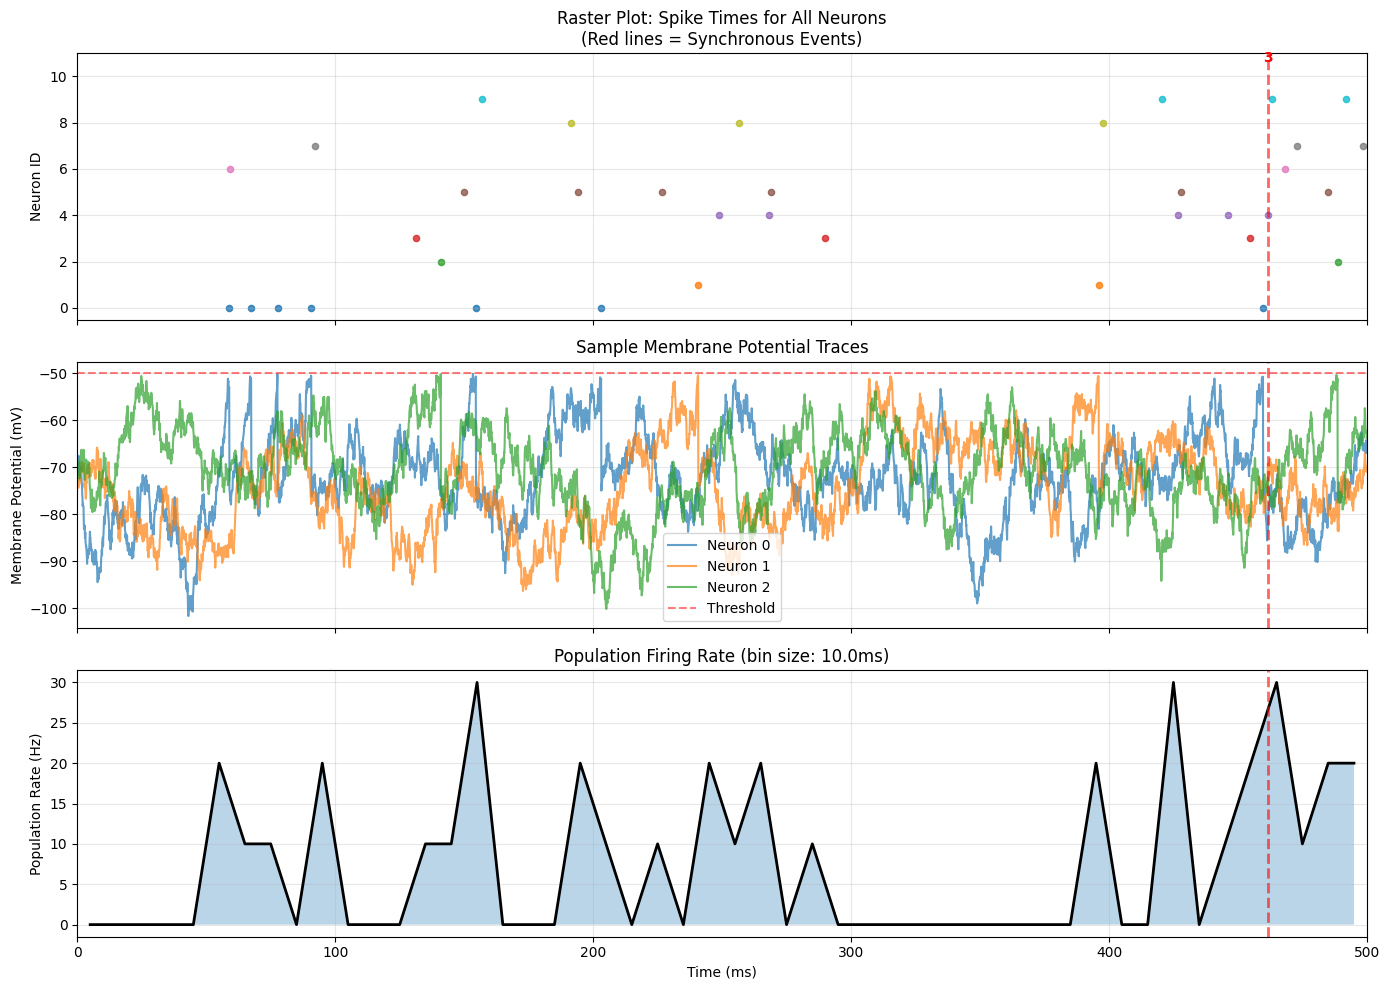


=== SYNCHRONY STATISTICS ===
Synchrony event sizes: [3]
Average synchrony size: 3.00 ± 0.00 neurons
Synchrony rate: 2.00 events/sec


In [2]:
"""
STOCHASTIC PROCESSES IN NEUROSCIENCE: Multi-Neuron Synchrony

This simulation demonstrates how NOISE can paradoxically create ORDER in neural systems.
We model multiple independent neurons, each driven by:
1. Deterministic dynamics (leaky integration)
2. Stochastic perturbations (random noise)

NOISE-DRIVEN SYNCHRONY:
   Even with INDEPENDENT noise sources, synchronous events emerge because:
   - Each neuron follows similar stochastic dynamics
   - Threshold crossings become correlated through shared statistical properties
   - This is a form of "noise-induced synchronization"

STATISTICAL MEASURES:
   - Inter-spike intervals follow exponential-like distributions
   - Synchrony detection uses temporal binning (sliding window)
   - Population dynamics emerge from single-neuron stochasticity

This bridges individual neuron randomness to collective neural computation!
"""

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Parameters ---
T = 500           # total time (ms) - longer to see more sync events
dt = 0.1          # time step (ms)
time = np.arange(0, T, dt)

# LIF neuron parameters
tau = 20.0        # membrane time constant (ms)
V_rest = -70.0    # resting potential (mV)
V_reset = -75.0   # reset potential after spike (mV)
V_thresh = -50.0  # spike threshold (mV)
R = 1.0           # membrane resistance
I_mean = 1.4      # mean input current (nA) - slightly reduced for more interesting dynamics
I_std = 0.2       # standard deviation of input current across neurons
sigma = 4.0       # noise strength
n_neurons = 10    # number of neurons to simulate

# Synchrony detection parameters
sync_window = 2.0  # time window for considering spikes synchronous (ms)
min_sync_neurons = 3  # minimum number of neurons that must spike together

# --- Initialization ---
# Each neuron gets slightly different input current (heterogeneity)
I_neurons = np.random.normal(I_mean, I_std, n_neurons)

# Storage for all neurons
V = np.zeros((n_neurons, len(time)))
V[:, 0] = V_rest + np.random.normal(0, 2, n_neurons)  # random initial conditions

# Store spike times for each neuron
spike_times = [[] for _ in range(n_neurons)]
all_spikes = []  # (time, neuron_id) pairs

# --- Simulation loop ---
print("Simulating {} neurons...".format(n_neurons))

for i in range(1, len(time)):
    for n in range(n_neurons):
        # Independent noise for each neuron
        noise = np.random.normal(0, np.sqrt(dt))

        # LIF dynamics
        dV = (- (V[n, i-1] - V_rest) + R * I_neurons[n]) * (dt / tau) + sigma * noise
        V[n, i] = V[n, i-1] + dV

        # Spike detection and reset
        if V[n, i] >= V_thresh:
            V[n, i] = V_reset
            spike_times[n].append(time[i])
            all_spikes.append((time[i], n))

# --- Synchrony Detection ---
print("Detecting synchronous firing events...")

# Sort all spikes by time
all_spikes.sort(key=lambda x: x[0])

# Find synchronous events
sync_events = []
current_sync = []
last_spike_time = -np.inf

for spike_time, neuron_id in all_spikes:
    if spike_time - last_spike_time <= sync_window:
        # This spike is within the sync window
        current_sync.append((spike_time, neuron_id))
    else:
        # Check if previous group was synchronous
        if len(current_sync) >= min_sync_neurons:
            # Get unique neurons in this sync event
            neurons_in_sync = list(set([nid for _, nid in current_sync]))
            if len(neurons_in_sync) >= min_sync_neurons:
                sync_time = np.mean([st for st, _ in current_sync])
                sync_events.append((sync_time, neurons_in_sync))

        # Start new potential sync group
        current_sync = [(spike_time, neuron_id)]

    last_spike_time = spike_time

# Check final group
if len(current_sync) >= min_sync_neurons:
    neurons_in_sync = list(set([nid for _, nid in current_sync]))
    if len(neurons_in_sync) >= min_sync_neurons:
        sync_time = np.mean([st for st, _ in current_sync])
        sync_events.append((sync_time, neurons_in_sync))

# --- Analysis ---
total_spikes = sum(len(st) for st in spike_times)
firing_rates = [len(st) / (T/1000) for st in spike_times]  # Hz

print(f"\n=== SIMULATION RESULTS ===")
print(f"Total spikes: {total_spikes}")
print(f"Average firing rate: {np.mean(firing_rates):.2f} ± {np.std(firing_rates):.2f} Hz")
print(f"Synchronous events detected: {len(sync_events)}")

if sync_events:
    print("\nSynchronous firing events:")
    for i, (sync_time, neurons) in enumerate(sync_events):
        print(f"  Event {i+1}: {len(neurons)} neurons at t={sync_time:.1f}ms (neurons: {neurons})")

# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Raster plot
ax1 = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, n_neurons))

for n in range(n_neurons):
    spike_times_n = spike_times[n]
    if spike_times_n:
        ax1.scatter(spike_times_n, [n] * len(spike_times_n),
                   c=[colors[n]], s=20, alpha=0.8)

# Highlight synchronous events
for sync_time, neurons in sync_events:
    ax1.axvline(sync_time, color='red', alpha=0.6, linewidth=2, linestyle='--')
    # Add text annotation
    ax1.text(sync_time, n_neurons + 0.5, f'{len(neurons)}',
             ha='center', va='bottom', color='red', fontweight='bold')

ax1.set_ylabel('Neuron ID')
ax1.set_title('Raster Plot: Spike Times for All Neurons\n(Red lines = Synchronous Events)')
ax1.set_xlim(0, T)
ax1.set_ylim(-0.5, n_neurons + 1)
ax1.grid(True, alpha=0.3)

# 2. Sample membrane potentials (first 3 neurons)
ax2 = axes[1]
for n in range(min(3, n_neurons)):
    ax2.plot(time, V[n, :], label=f'Neuron {n}', alpha=0.7, color=colors[n])

ax2.axhline(V_thresh, color='r', linestyle='--', alpha=0.5, label='Threshold')
# Mark synchronous events
for sync_time, neurons in sync_events:
    ax2.axvline(sync_time, color='red', alpha=0.6, linewidth=2, linestyle='--')

ax2.set_ylabel('Membrane Potential (mV)')
ax2.set_title('Sample Membrane Potential Traces')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Population firing rate over time
ax3 = axes[2]
bin_size = 10.0  # ms
bins = np.arange(0, T + bin_size, bin_size)
population_rate = np.zeros(len(bins) - 1)

for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
    spike_count = 0
    for n in range(n_neurons):
        spike_count += len([st for st in spike_times[n] if start <= st < end])
    population_rate[i] = spike_count / (bin_size / 1000.0) / n_neurons  # Hz

bin_centers = (bins[:-1] + bins[1:]) / 2
ax3.plot(bin_centers, population_rate, 'k-', linewidth=2)
ax3.fill_between(bin_centers, population_rate, alpha=0.3)

# Mark synchronous events
for sync_time, neurons in sync_events:
    ax3.axvline(sync_time, color='red', alpha=0.6, linewidth=2, linestyle='--')

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Population Rate (Hz)')
ax3.set_title(f'Population Firing Rate (bin size: {bin_size}ms)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Additional Analysis: Synchrony Statistics ---
if sync_events:
    sync_sizes = [len(neurons) for _, neurons in sync_events]
    sync_intervals = []
    if len(sync_events) > 1:
        sync_intervals = [sync_events[i][0] - sync_events[i-1][0]
                         for i in range(1, len(sync_events))]

    print(f"\n=== SYNCHRONY STATISTICS ===")
    print(f"Synchrony event sizes: {sync_sizes}")
    print(f"Average synchrony size: {np.mean(sync_sizes):.2f} ± {np.std(sync_sizes):.2f} neurons")
    if sync_intervals:
        print(f"Inter-sync intervals: {np.mean(sync_intervals):.1f} ± {np.std(sync_intervals):.1f} ms")

    # Synchrony rate
    sync_rate = len(sync_events) / (T / 1000.0)  # events per second
    print(f"Synchrony rate: {sync_rate:.2f} events/sec")
else:
    print("\nNo synchronous events detected. Try:")
    print("- Increasing noise strength (sigma)")
    print("- Reducing sync_window or min_sync_neurons")
    print("- Running longer simulation (T)")

## **Conclusion: From Mathematical Noise to Neural Computation**

This exploration has revealed that noise in neural systems is not a flaw to be eliminated but a fundamental feature that enables flexibility, robustness, and emergent computation.

By moving from deterministic ODEs to stochastic differential equations, we've seen how randomness at the level of individual neurons can give rise to coherent population dynamics—even synchrony—without direct connections.

The Euler-Maruyama method allowed us to bridge continuous stochastic theory with discrete simulation, showing that variability is not a nuisance but a computational resource. Stochastic models better capture real neural behavior under uncertainty, explain phenomena like oscillations, and reveal how the brain uses randomness to explore possibilities and make decisions. Clinically, altered noise dynamics may underlie disorders like epilepsy, suggesting new therapeutic avenues.

Ultimately, the brain is not a deterministic machine but a stochastic system where noise drives intelligence, adaptability, and even consciousness. Embracing this variability gives us a more powerful lens for understanding the brain—not despite its randomness, but because of it.